In [130]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Contribution Analysis

In this session, how does each feature contribute to random forest decision making will be analysed. 
## 1. Load feature contribution matrix and group by cluster id

In [69]:
fc_df = pd.read_pickle('data/fc_df.pkl')

In [70]:
summary = fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])
summary.columns = ['employment_rate','sample_size']
summary

,employment_rate,sample_size
cluster,,
0,0.058565,683
1,0.927550,2098
2,0.077778,360
3,0.067839,398
4,0.895210,668
5,0.889313,262


**Cluster 0,2,3** are unemployed groups. **Cluster 1,4,5** are employed groups. 


### Load original survey data

In [158]:
sv = survey('data/survey2')
sv.num_processor()
df = pd.concat([sv.fin_data[sv.num_cols],sv.data[sv.sv_cols],sv.fin_data.employed],axis =1)

f31 = fc_df.columns[:31]
df31= df[f31]
l = list(df31.columns)
l.append('cluster')

new = np.column_stack((df31.values,fc_df.cluster))
df = pd.DataFrame(new,columns=l)

## Unemployed Clusters

### Cluster 0

In [72]:
c0 = fc_df[fc_df.cluster == 0]

In [73]:
sort_feature_means(c0,10)

[(-0.037370748829345088, 'age'),
 (-0.035867872897539836, 'educom'),
 (-0.032106094296888495, 'sphrs1'),
 (-0.024519725370472405, 'agekdbrn'),
 (-0.021255684375609853, 'divorce'),
 (-0.019506785944929821, 'partyid'),
 (-0.017024391535317502, 'polviews'),
 (-0.016792892486347143, 'res16'),
 (-0.01645438550821406, 'incom16'),
 (-0.013795521161037029, 'reliten')]

In [160]:
df_c0 = df[df.cluster ==0]

In [169]:
df_c0.fefam.value_counts()

Not applicable       293
Disagree             170
Agree                118
Strongly disagree     53
Strongly agree        44
Don't know             5
Name: fefam, dtype: int64

In [170]:
df_c0.age.mean()

36.165446559297216

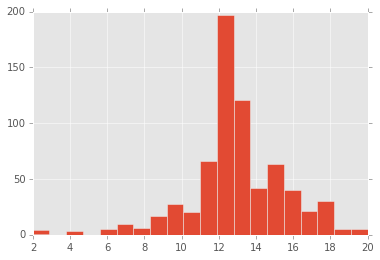

In [174]:
df_c0.educom.hist(bins = 20)

In [175]:
df_c0.divorce.value_counts()

No                501
Not applicable     96
Yes                83
No answer           3
Name: divorce, dtype: int64

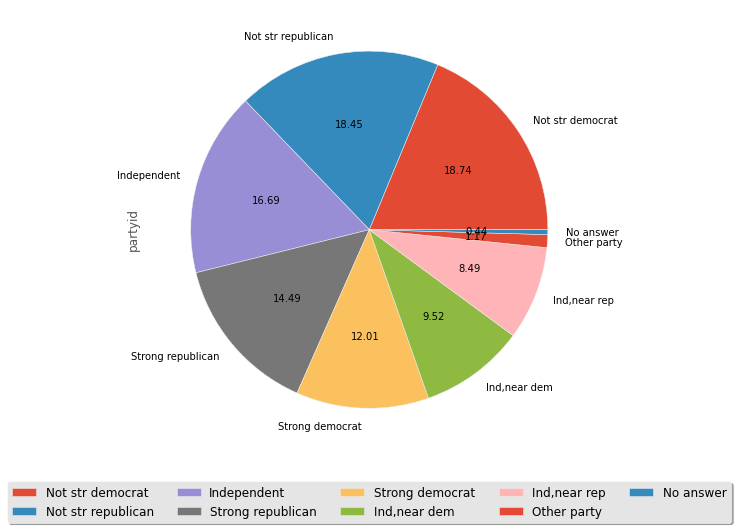

In [177]:
simple_pie(df_c0.partyid)

In [184]:
df_c0.describe().ix[2:,:].T

,top,freq
coninc,121553,21
age,35,39
educom,12.3333,89
degree,High school,397
sphrs1,98,164
partyid,Not str democrat,128
agekdbrn,98,68
class_,Middle class,323
dwelling,Detached 1-fam house,492
polviews,Moderate,231


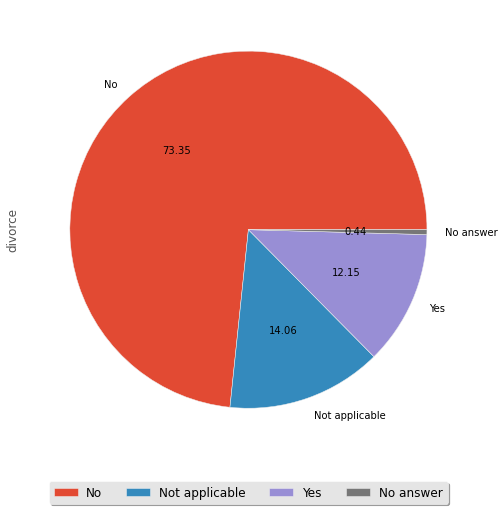

In [192]:
simple_pie(df_c0.divorce)

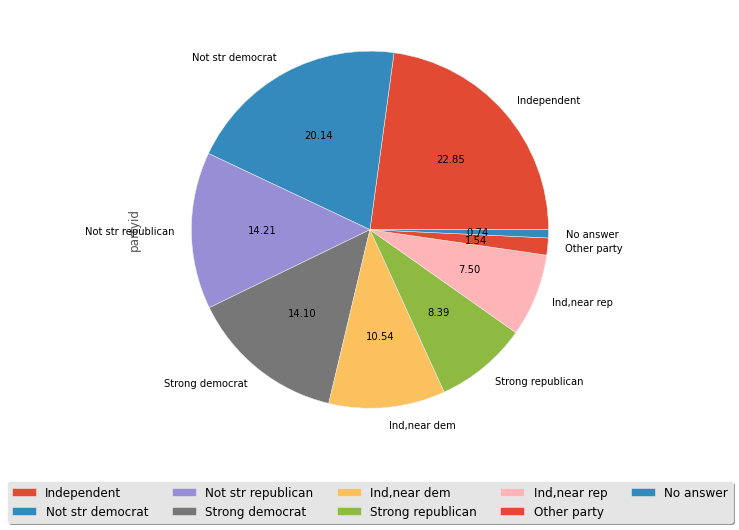

In [194]:
simple_pie(df.partyid)

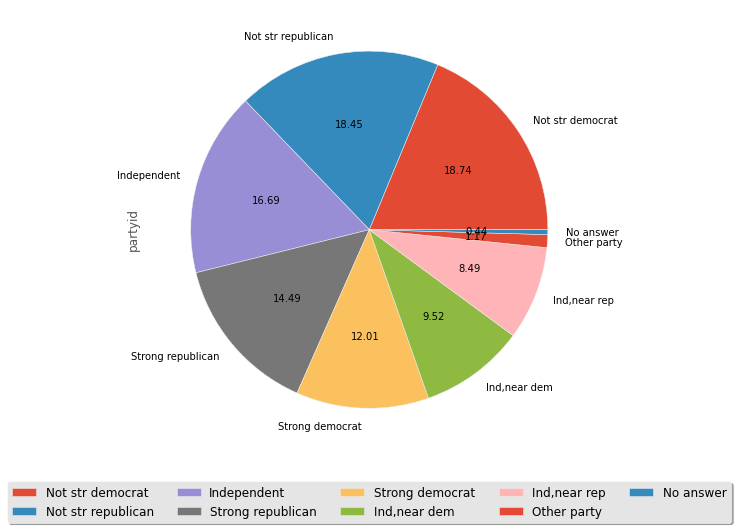

In [195]:
simple_pie(df_c0.partyid)

In [117]:
y = fc_df.cluster

In [125]:
np.column_stack((x,y)).shape

(4469, 4)

In [122]:
y.shape

(4469,)